In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
df = pd.read_csv(r"C:\Users\ASUS\Downloads\chennai_rainfall_2019_2023_mm.csv")

print(df.head())
print(df.info())

         Date  Year  Month  Temperature (°C)  Humidity (%)  Wind Speed (km/h)  \
0  2019-01-01  2019      1              31.0          74.5               13.3   
1  2019-01-02  2019      1              29.7          87.1                9.5   
2  2019-01-03  2019      1              31.3          79.5               12.4   
3  2019-01-04  2019      1              33.0          80.1               13.1   
4  2019-01-05  2019      1              29.5          83.5               12.0   

   Rainfall (cm)  Rainfall (mm)  
0            0.5            5.0  
1            0.1            1.0  
2            0.3            3.0  
3            0.1            1.0  
4            1.4           14.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1826 non-null   object 
 1   Year               1826 non-null   int64  
 2   Month 

In [4]:
# Log-transform target
df['Rainfall (cm)'] = np.log1p(df['Rainfall (cm)'])
# Define features (X) and target (y)
X = df.drop(['Rainfall (cm)','Rainfall (mm)','Date'], axis=1).values
y = df['Rainfall (cm)'].values

# Scale features (0–1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=True, random_state=42
)

In [6]:
def build_ann(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),

        Dense(1)  # regression output
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='mse', metrics=['mae'])
    return model

ann_model = build_ann(X_train.shape[1])


In [7]:
# Callbacks
callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=10, verbose=1)
]

In [8]:
# =======================
# 3. Train Model
# =======================
history = ann_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200, batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/200
46/46 [==============================] - 2s 16ms/step - loss: 1.9688 - mae: 1.0900 - val_loss: 0.4778 - val_mae: 0.4956 - lr: 5.0000e-04
Epoch 2/200
46/46 [==============================] - 0s 4ms/step - loss: 1.1074 - mae: 0.8364 - val_loss: 0.3646 - val_mae: 0.4626 - lr: 5.0000e-04
Epoch 3/200
46/46 [==============================] - 0s 4ms/step - loss: 0.7585 - mae: 0.6862 - val_loss: 0.3317 - val_mae: 0.4622 - lr: 5.0000e-04
Epoch 4/200
46/46 [==============================] - 0s 4ms/step - loss: 0.6073 - mae: 0.6113 - val_loss: 0.3155 - val_mae: 0.4695 - lr: 5.0000e-04
Epoch 5/200
46/46 [==============================] - 0s 4ms/step - loss: 0.5436 - mae: 0.5807 - val_loss: 0.3135 - val_mae: 0.4756 - lr: 5.0000e-04
Epoch 6/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4561 - mae: 0.5427 - val_loss: 0.3174 - val_mae: 0.4831 - lr: 5.0000e-04
Epoch 7/200
46/46 [==============================] - 0s 4ms/step - loss: 0.4273 - mae: 0.5131 - val_loss: 0.311

In [9]:
y_pred = ann_model.predict(X_test).flatten()

12/12 [==============================] - 0s 2ms/step


In [10]:
# Inverse log-transform
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2   = r2_score(y_test_actual, y_pred_actual)

print(f"Improved ANN Performance:")
print(f"  RMSE: {rmse:.4f}")
print(f"  R² Score: {r2:.4f}")


Improved ANN Performance:
  RMSE: 1.5174
  R² Score: 0.2545


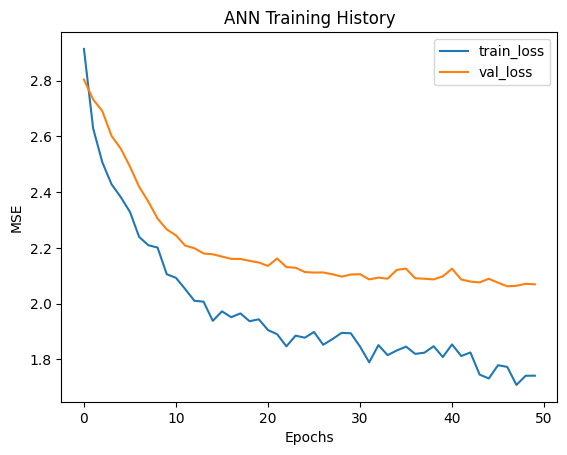

In [9]:
def plot_history(history, title):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

plot_history(history, "ANN Training History")


In [10]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R² Score: {r2:.4f}\n")
    return rmse, r2

# ANN evaluation
y_pred_ann = model.predict(X_test).flatten()
evaluate_model(y_test, y_pred_ann, "ANN")

12/12 [==============================] - 0s 891us/step
ANN Performance:
  RMSE: 1.4385
  R² Score: 0.3300



(1.4385327623249728, 0.3299996723939477)